In [121]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np

import vae_cats
from config_cats import device, BATCH_SIZE, EPOCHS

# Load the dataset

In [ ]:
! git clone https://github.com/fferlito/Cat-faces-dataset.git

Cloning into 'Cat-faces-dataset'...
Updating files:  85% (6/7)
Updating files: 100% (7/7)
Updating files: 100% (7/7), done.


In [102]:
import gzip
import os
import shutil

# Directory containing the .gz files
gz_dir = "Cat-faces-dataset"
output_dir = "Cat-faces-dataset/extracted_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Extract each .gz file
for gz_file in os.listdir(gz_dir):
    if gz_file.endswith(".gz"):
        gz_path = os.path.join(gz_dir, gz_file)
        output_path = os.path.join(output_dir, os.path.splitext(gz_file)[0])  # Remove .gz extension
        with gzip.open(gz_path, 'rb') as f_in:
            with open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

print("Extraction complete! Files saved to:", output_dir)

Extraction complete! Files saved to: Cat-faces-dataset/extracted_images


In [103]:
import tarfile

# Directory containing the .tar files
tar_dir = "Cat-faces-dataset/extracted_images"
output_dir = "Cat-faces-dataset/final_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Extract each .tar file
for tar_file in os.listdir(tar_dir):
    if tar_file.endswith(".tar"):
        tar_path = os.path.join(tar_dir, tar_file)
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path=output_dir)

print("Extraction complete! Files saved to:", output_dir)


Extraction complete! Files saved to: Cat-faces-dataset/final_images


In [10]:
# Flatten the directory structure
base_dir = "Cat-faces-dataset/final_images"
all_cats_dir = os.path.join(base_dir, "all_cats")
os.makedirs(all_cats_dir, exist_ok=True)

for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith((".jpg", ".png")):  # Include valid image formats
            shutil.move(os.path.join(root, file), all_cats_dir)

print("All images moved to:", all_cats_dir)


All images moved to: Cat-faces-dataset/final_images\all_cats


# Train the model

In [126]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert to tensor
])


data_dir = "Cat-faces-dataset/final_images/cats"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [108]:
from PIL import Image
img = Image.open("Cat-faces-dataset/final_images/cats/all_cats/cat_0.png")

img.show()

In [109]:

img_array = np.array(img)
print(img_array.min(), img_array.max())

0 252


In [117]:
images = next(iter(train_loader))[0]
print(images.min(), images.max())

tensor(0.) tensor(1.)


In [ ]:
import matplotlib.pyplot as plt

def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    tensor = tensor.clone()
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])  # Undo normalization
    return tensor.clamp(0, 1)  # Clamp to valid range

plt.close('all')
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
# Visualize images
for images, _ in train_loader:
    for i in range(5):  # Visualize the first 5 images
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format for display
        axs[i].imshow(img)
        axs[i].axis('off')

    break
plt.show()

In [128]:
trained_model = vae_cats.VariationalAutoencoder().to(device)

losses = []
print(EPOCHS)
for epoch in range(EPOCHS):  
    loss = vae_cats.train(trained_model, train_loader)
    losses.append(loss)

10


In [142]:
torch.save(trained_model.state_dict(), "vae_cats_model_10.pth")

In [143]:
torch.save(trained_model, "vae_cats_model_full_10.pth")

In [ ]:
# Reinitialize the model architecture
trained_model = vae_cats.VariationalAutoencoder().to(device)  # Ensure the architecture matches the saved model
trained_model.load_state_dict(torch.load("vae_cats_model.pth"))
trained_model.eval()  # Set the model to evaluation mode

# Plot the model loss across epochs

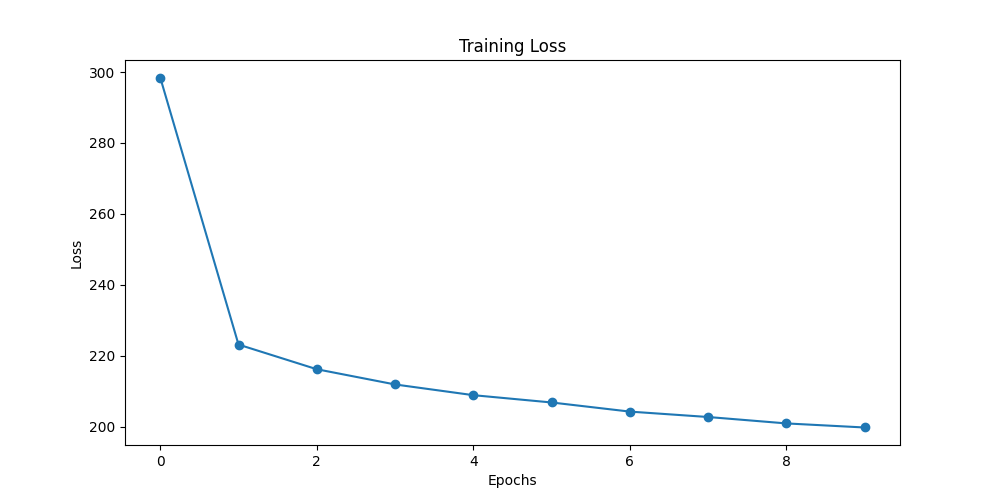

In [129]:
vae_cats.plot_loss(losses)

# Test the model (qualitatively)

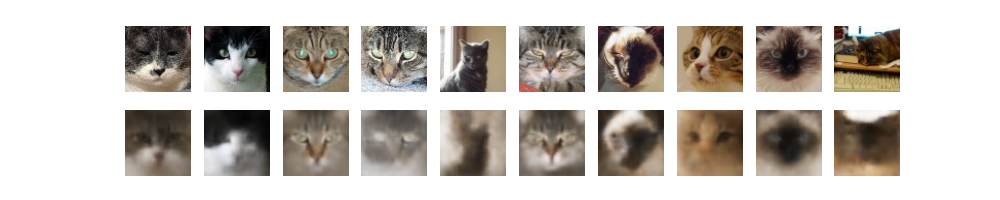

In [130]:
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

vae_cats.visualize_reconstructions(trained_model, test_loader)

# Generate new cats

In [131]:
plot_samples = 10
num_samples = 100  # Number of digits you want to generate
z, generated_cats = vae_cats.generate_new_cats(trained_model, num_samples)

torch.Size([100, 3, 64, 64])


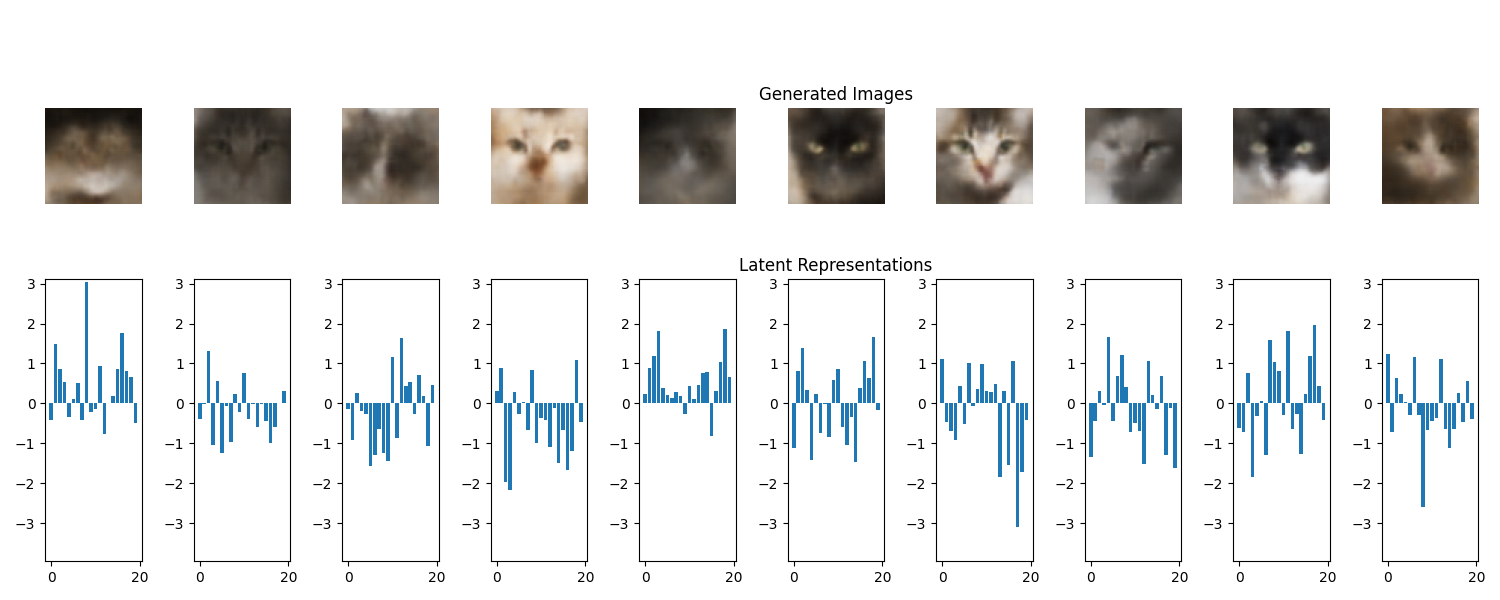

In [132]:
vae_cats.plot_images_and_latents(z, generated_cats, plot_samples)

# Project the latent space into 2d space (using t-NSE alg)

In [133]:
project_loader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Get a batch of data
data, labels = next(iter(project_loader))
data = data.to(device)
labels = labels.numpy()  

# Use the encoder to get the latent variables
trained_model.eval()
with torch.no_grad():
    mu, _ = trained_model.encode(data)
    mu = mu.cpu().numpy()  # Convert to NumPy array for visualization

In [141]:
new_labels = np.concatenate([labels, [11 for i in range(plot_samples)]])

In [146]:
tsne = TSNE(n_components=2, random_state=0)
full_latent_vectors = np.vstack([mu, z[0:plot_samples]])
latent_tsne = tsne.fit_transform(full_latent_vectors)  # Use latent space representations for visualization

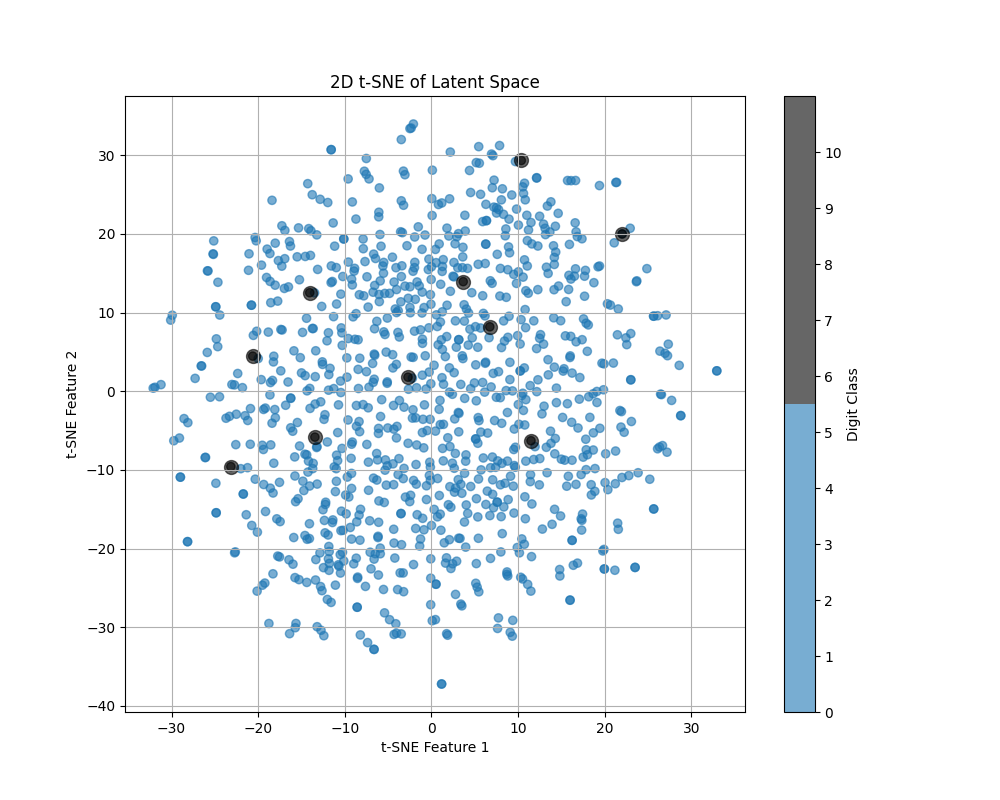

In [147]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(10, 8))

colors = ['#1f77b4', '#000000']
custom_cmap = ListedColormap(colors)

scatter = ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=new_labels, cmap=custom_cmap, alpha=0.6)
ax.scatter(latent_tsne[-plot_samples:, 0], latent_tsne[-plot_samples:, 1], c='k', s=100, alpha=0.6)

fig.colorbar(scatter, ticks=range(11), label='Digit Class')
ax.set_title('2D t-SNE of Latent Space')
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.grid(True)
plt.show()